In [1]:
# Pretty colors
BLACK = "k"
GREEN = "#59d98e"
SEA = "#159d82"
BLUE = "#3498db"
PURPLE = "#9b59b6"
GREY = "#95a5a6"
RED = "#e74c3c"
ORANGE = "#f39c12"

In [2]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import matplotlib.pyplot as plt
import pandas as pd
import pickle
sns.set()

In [3]:
import json
import torch
from sentence_transformers import SentenceTransformer, util
import pandas as pd
pd.set_option('display.max_columns', None)
with open('repobench/data/easy_fixed.jsonl', 'r') as json_file:
    raw_data = list(json_file)
len(raw_data)

12000

In [4]:
data = [json.loads(row) for row in raw_data]

In [5]:
gold_snippets = [data[i]['gold_snippet_index'] for i in range(len(data))]

In [6]:
# for row in data:
#     row['cropped_context'] = ['\n'.join(row['context'][i].split('\n')[:5]) for i in range(len(row['context']))]

In [29]:
%%time
from transformers import AutoTokenizer, AutoModel, utils
utils.logging.set_verbosity_error()  # Suppress standard warnings
sentences  = [row['next_line'] for row in data[:1000]]
raw_attns = []
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L12-v2')
model = AutoModel.from_pretrained('sentence-transformers/all-MiniLM-L12-v2', output_attentions=True)

encoded_input = tokenizer(sentences, padding=True, truncation=True, return_tensors='pt')
with torch.no_grad():
    model_output = model(**encoded_input)
# tokens = tokenizer.convert_ids_to_tokens(encoded_input['input_ids'][0])  

CPU times: user 1min 12s, sys: 34.6 s, total: 1min 47s
Wall time: 23.1 s


In [63]:
orig_tokens = [tokenizer.convert_ids_to_tokens(enc_inp) for enc_inp in encoded_input['input_ids']]
len(orig_tokens)

1000

In [64]:
n_docs = 1000

In [67]:
np.array(model_output.attentions).shape

(12, 1000, 12, 76, 76)

In [70]:
attentions_tr = np.einsum('abcde->bacde', model_output.attentions)
attentions_tr.shape

(1000, 12, 12, 76, 76)

In [74]:
avg_attns = {
    k: np.zeros((12, 12)) for k in [
      "self", "right", "left", "sep", "sep_sep", "rest_sep",
      "cls", "punct"]
}

print("Computing token stats")
for tokens, attns in zip(orig_tokens, attentions_tr):
  n_tokens = len(tokens)#attns.shape[-1]

  # create masks indicating where particular tokens are
  seps, clss, puncts = (np.zeros(n_tokens) for _ in range(3))
  for position, token in enumerate(tokens):
    if token == "[SEP]":
      seps[position] = 1
    if token == "[CLS]":
      clss[position] = 1
    if token == "." or token == ",":
      puncts[position] = 1

  # create masks indicating which positions are relevant for each key
  sep_seps = np.ones((n_tokens, n_tokens))
  sep_seps *= seps[np.newaxis]
  sep_seps *= seps[:, np.newaxis]

  rest_seps = np.ones((n_tokens, n_tokens))
  rest_seps *= (np.ones(n_tokens) - seps)[:, np.newaxis]
  rest_seps *= seps[np.newaxis]

  selectors = {
      "self": np.eye(n_tokens, n_tokens),
      "right": np.eye(n_tokens, n_tokens, 1),
      "left": np.eye(n_tokens, n_tokens, -1),
      "sep": np.tile(seps[np.newaxis], [n_tokens, 1]),
      "sep_sep": sep_seps,
      "rest_sep": rest_seps,
      "cls": np.tile(clss[np.newaxis], [n_tokens, 1]),
      "punct": np.tile(puncts[np.newaxis], [n_tokens, 1]),
  }

  # get the average attention for each token type
  for key, selector in selectors.items():
    if key == "sep_sep":
      denom = 2
    elif key == "rest_sep":
      denom = n_tokens - 2
    else:
      denom = n_tokens
    # print((attns * selector[np.newaxis, np.newaxis]).sum(-1).sum(-1))
    avg_attns[key] = avg_attns[key] + (
        (attns * selector[np.newaxis, np.newaxis]).sum(-1).sum(-1) /
        (n_docs * denom)).reshape(12, 12)

Computing token stats


In [76]:
def get_data_points(head_data):
  xs, ys, avgs = [], [], []
  for layer in range(12):
    for head in range(12):
      ys.append(head_data[layer, head])
      xs.append(1 + layer)
    avgs.append(head_data[layer].mean())
  return xs, ys, avgs

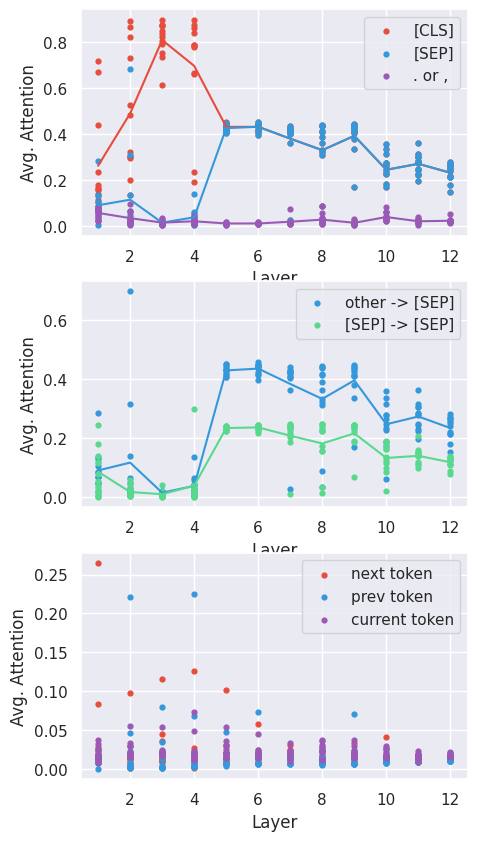

In [77]:
def add_line(key, ax, color, label, plot_avgs=True):
  xs, ys, avgs = get_data_points(avg_attns[key])
  ax.scatter(xs, ys, s=12, label=label, color=color)
  if plot_avgs:
    ax.plot(1 + np.arange(len(avgs)), avgs, color=color)
  ax.legend(loc="best")
  ax.set_xlabel("Layer")
  ax.set_ylabel("Avg. Attention")


plt.figure(figsize=(5, 10))
ax = plt.subplot(3, 1, 1)
for key, color, label in [
    ("cls", RED, "[CLS]"),
    ("sep", BLUE, "[SEP]"),
    ("punct", PURPLE, ". or ,"),
]:
    add_line(key, ax, color, label)

ax = plt.subplot(3, 1, 2)
for key, color, label in [
    ("rest_sep", BLUE, "other -> [SEP]"),
    ("sep_sep", GREEN, "[SEP] -> [SEP]"),
]:
  add_line(key, ax, color, label)

ax = plt.subplot(3, 1, 3)
for key, color, label in [
    ("left", RED, "next token"),
    ("right", BLUE, "prev token"),
    ("self", PURPLE, "current token"),
]:
    add_line(key, ax, color, label, plot_avgs=False)

plt.show()

## e5

In [78]:
%%time
from transformers import AutoTokenizer, AutoModel, utils
utils.logging.set_verbosity_error()  # Suppress standard warnings
sentences  = [row['next_line'] for row in data[:1000]]
raw_attns = []
tokenizer = AutoTokenizer.from_pretrained('intfloat/e5-large')
model = AutoModel.from_pretrained('intfloat/e5-large', output_attentions=True)

encoded_input = tokenizer(sentences, padding=True, truncation=True, return_tensors='pt')
with torch.no_grad():
    model_output = model(**encoded_input)
# tokens = tokenizer.convert_ids_to_tokens(encoded_input['input_ids'][0])  

CPU times: user 13min 39s, sys: 6min 34s, total: 20min 14s
Wall time: 3min 41s


In [79]:
orig_tokens = [tokenizer.convert_ids_to_tokens(enc_inp) for enc_inp in encoded_input['input_ids']]
len(orig_tokens)

1000

In [80]:
n_docs = 1000

In [81]:
np.array(model_output.attentions).shape

(24, 1000, 16, 76, 76)

In [82]:
attentions_tr = np.einsum('abcde->bacde', model_output.attentions)
attentions_tr.shape

(1000, 24, 16, 76, 76)

In [84]:
avg_attns = {
    k: np.zeros((24, 16)) for k in [
      "self", "right", "left", "sep", "sep_sep", "rest_sep",
      "cls", "punct"]
}

print("Computing token stats")
for tokens, attns in zip(orig_tokens, attentions_tr):
  n_tokens = len(tokens)#attns.shape[-1]

  # create masks indicating where particular tokens are
  seps, clss, puncts = (np.zeros(n_tokens) for _ in range(3))
  for position, token in enumerate(tokens):
    if token == "[SEP]":
      seps[position] = 1
    if token == "[CLS]":
      clss[position] = 1
    if token == "." or token == ",":
      puncts[position] = 1

  # create masks indicating which positions are relevant for each key
  sep_seps = np.ones((n_tokens, n_tokens))
  sep_seps *= seps[np.newaxis]
  sep_seps *= seps[:, np.newaxis]

  rest_seps = np.ones((n_tokens, n_tokens))
  rest_seps *= (np.ones(n_tokens) - seps)[:, np.newaxis]
  rest_seps *= seps[np.newaxis]

  selectors = {
      "self": np.eye(n_tokens, n_tokens),
      "right": np.eye(n_tokens, n_tokens, 1),
      "left": np.eye(n_tokens, n_tokens, -1),
      "sep": np.tile(seps[np.newaxis], [n_tokens, 1]),
      "sep_sep": sep_seps,
      "rest_sep": rest_seps,
      "cls": np.tile(clss[np.newaxis], [n_tokens, 1]),
      "punct": np.tile(puncts[np.newaxis], [n_tokens, 1]),
  }

  # get the average attention for each token type
  for key, selector in selectors.items():
    if key == "sep_sep":
      denom = 2
    elif key == "rest_sep":
      denom = n_tokens - 2
    else:
      denom = n_tokens
    # print((attns * selector[np.newaxis, np.newaxis]).sum(-1).sum(-1))
    avg_attns[key] = avg_attns[key] + (
        (attns * selector[np.newaxis, np.newaxis]).sum(-1).sum(-1) /
        (n_docs * denom)).reshape(24, 16)

Computing token stats


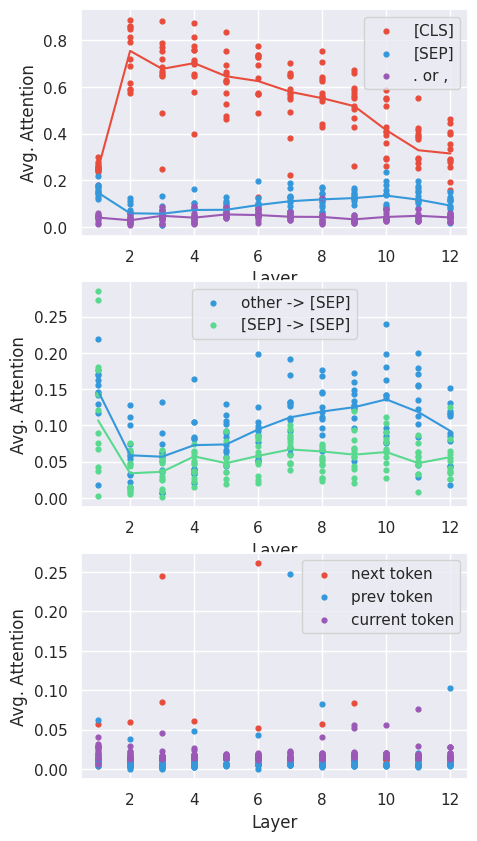

In [85]:
plt.figure(figsize=(5, 10))
ax = plt.subplot(3, 1, 1)
for key, color, label in [
    ("cls", RED, "[CLS]"),
    ("sep", BLUE, "[SEP]"),
    ("punct", PURPLE, ". or ,"),
]:
    add_line(key, ax, color, label)

ax = plt.subplot(3, 1, 2)
for key, color, label in [
    ("rest_sep", BLUE, "other -> [SEP]"),
    ("sep_sep", GREEN, "[SEP] -> [SEP]"),
]:
  add_line(key, ax, color, label)

ax = plt.subplot(3, 1, 3)
for key, color, label in [
    ("left", RED, "next token"),
    ("right", BLUE, "prev token"),
    ("self", PURPLE, "current token"),
]:
    add_line(key, ax, color, label, plot_avgs=False)

plt.show()

## 